In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns
import pickle
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
import urllib.request
from PIL import Image

In [3]:
path = '/content/drive/MyDrive/CV++'
train_path = path + '/cityscapes_data/train'
val_path = path + '/cityscapes_data/val'

In [4]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

<a class="anchor" id="2" name="2"></a>
## **Prepare data**

In [5]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array
    
    return image, mask

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask

In [6]:
def preprocess(path, img_size):
    image, mask = image_mask_split(path, img_size)
    mask_enc = find_closest_labels_vectorized(mask, id2color)
    return image, mask_enc, mask

In [7]:
# save processed data to file for future use
def save_list_to_file(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

In [8]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to 

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )
#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground' 
          , 8       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),]
mapping_20 = { 
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 8,
        9: 1,
        10: 1,
        11: 2,
        12: 2,
        13: 2,
        14: 2,
        15: 2,
        16: 2,
        17: 3,
        18: 3,
        19: 3,
        20: 3,        
        21: 4,
        22: 4,
        23: 5,
        24: 6,
        25: 6,
        26: 7,
        27: 7,
        28: 7,
        29: 7,
        30: 7,
        31: 7,
        32: 7,
        33: 7,
        -1: 7
    }

In [9]:
BATCH_SIZE = 32
id2color = { label.id : np.asarray(label.color) for label in labels }
num_classes = len(id2color.keys())
width, height = 128, 128
IMAGE_SIZE = [width, height]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

In [10]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
                y_true=None,
                y_pred=None,
                num_classes=None,
                name=None,ignore_class=None,
                dtype=None,sparse_y_true = True,sparse_y_pred = True, axis = -1):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype,)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None,):
        if (epoch % 5 == 0):

            img, mask, _ = preprocess(os.path.join(self.file_path),IMAGE_SIZE)
            pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
            pred = np.squeeze(np.argmax(pred, axis=-1))
            
            tmp1 = np.zeros([mask.shape[0], mask.shape[1], 3])
            tmp2 = np.zeros([mask.shape[0], mask.shape[1], 3])
            
            
            for row in range(mask.shape[0]):
                for col in range(mask.shape[1]):
                    tmp1[row, col, :] = id2color[mask[row, col]]
                    tmp1 = tmp1.astype('uint8')
                            
                    tmp2[row, col, :] = id2color[pred[row, col]]
                    tmp2 = tmp2.astype('uint8')
                        
            fig, axes = plt.subplots(nrows = 1, ncols = 2)
            axes[0].imshow(tmp1, cmap='viridis')
            axes[0].set_title("Original Mask")
            axes[1].imshow(tmp2, cmap='viridis')
            axes[1].set_title("Predicted Mask")
            axes[0].grid(False)
            axes[1].grid(False)
            plt.tight_layout()
            plt.show()

class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
        self.max_iou: float = 0

    def on_epoch_end(self, epoch, logs=None,):
        if (epoch % 10 == 0 and logs['val_accuracy'] > self.max_iou):
            self.max_iou = logs['val_accuracy']
            model.save(self.file_path + f"/epoch{epoch:<4d}_({logs['val_mean_iou']:.4f}).h5")
            print(f"\tSave epoch{epoch:<4d} val_mean_iou: ({logs['val_mean_iou']:.4f}).h5")

def plot_history(history):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
    # Training
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1), y=history.history["loss"], ax = axes[0], label="Training Loss")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["accuracy"], ax = axes[1], label="Training Accuracy")
    sns.lineplot(x=range(1, len(history.history["loss"]) + 1), y=history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

    # Validation
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_loss"], ax = axes[0], label="Validation Loss")
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
    sns.lineplot(x= range(1, len(history.history["loss"]) + 1),y= history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")

    axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Mean IOU")
    plt.tight_layout()
    plt.show()

# Load data


In [11]:
path_pkl = '/content/drive/MyDrive/CV++/data/'
def load_list_from_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

train_images = load_list_from_file(path_pkl + 'train_images.pkl')
train_masks_enc = load_list_from_file(path_pkl + 'train_masks_enc.pkl')
val_images = load_list_from_file(path_pkl + 'val_images.pkl')
val_masks_enc = load_list_from_file(path_pkl + 'val_masks_enc.pkl')
train_masks = load_list_from_file(path_pkl + 'train_masks.pkl')
val_masks = load_list_from_file(path_pkl + 'val_masks.pkl')

# Load model

In [12]:
# model_path = os.path.join(path,'mode_save/checkpoint_for_each_epoch/')
model_path_unet = os.path.join(path,'model_save/Unet_model40.h5')
model_path_hrnet = os.path.join(path,'model_save/hrnet_earlystopping.h5')

# model = tf.keras.models.load_model(model_path,)
with tf.keras.utils.custom_object_scope({'UpdatedMeanIoU': UpdatedMeanIoU}):
    model_unet = tf.keras.models.load_model(model_path_unet)
    model_hrnet = tf.keras.models.load_model(model_path_hrnet)

# Show result


1/1 [==============================] - 0s 37ms/step


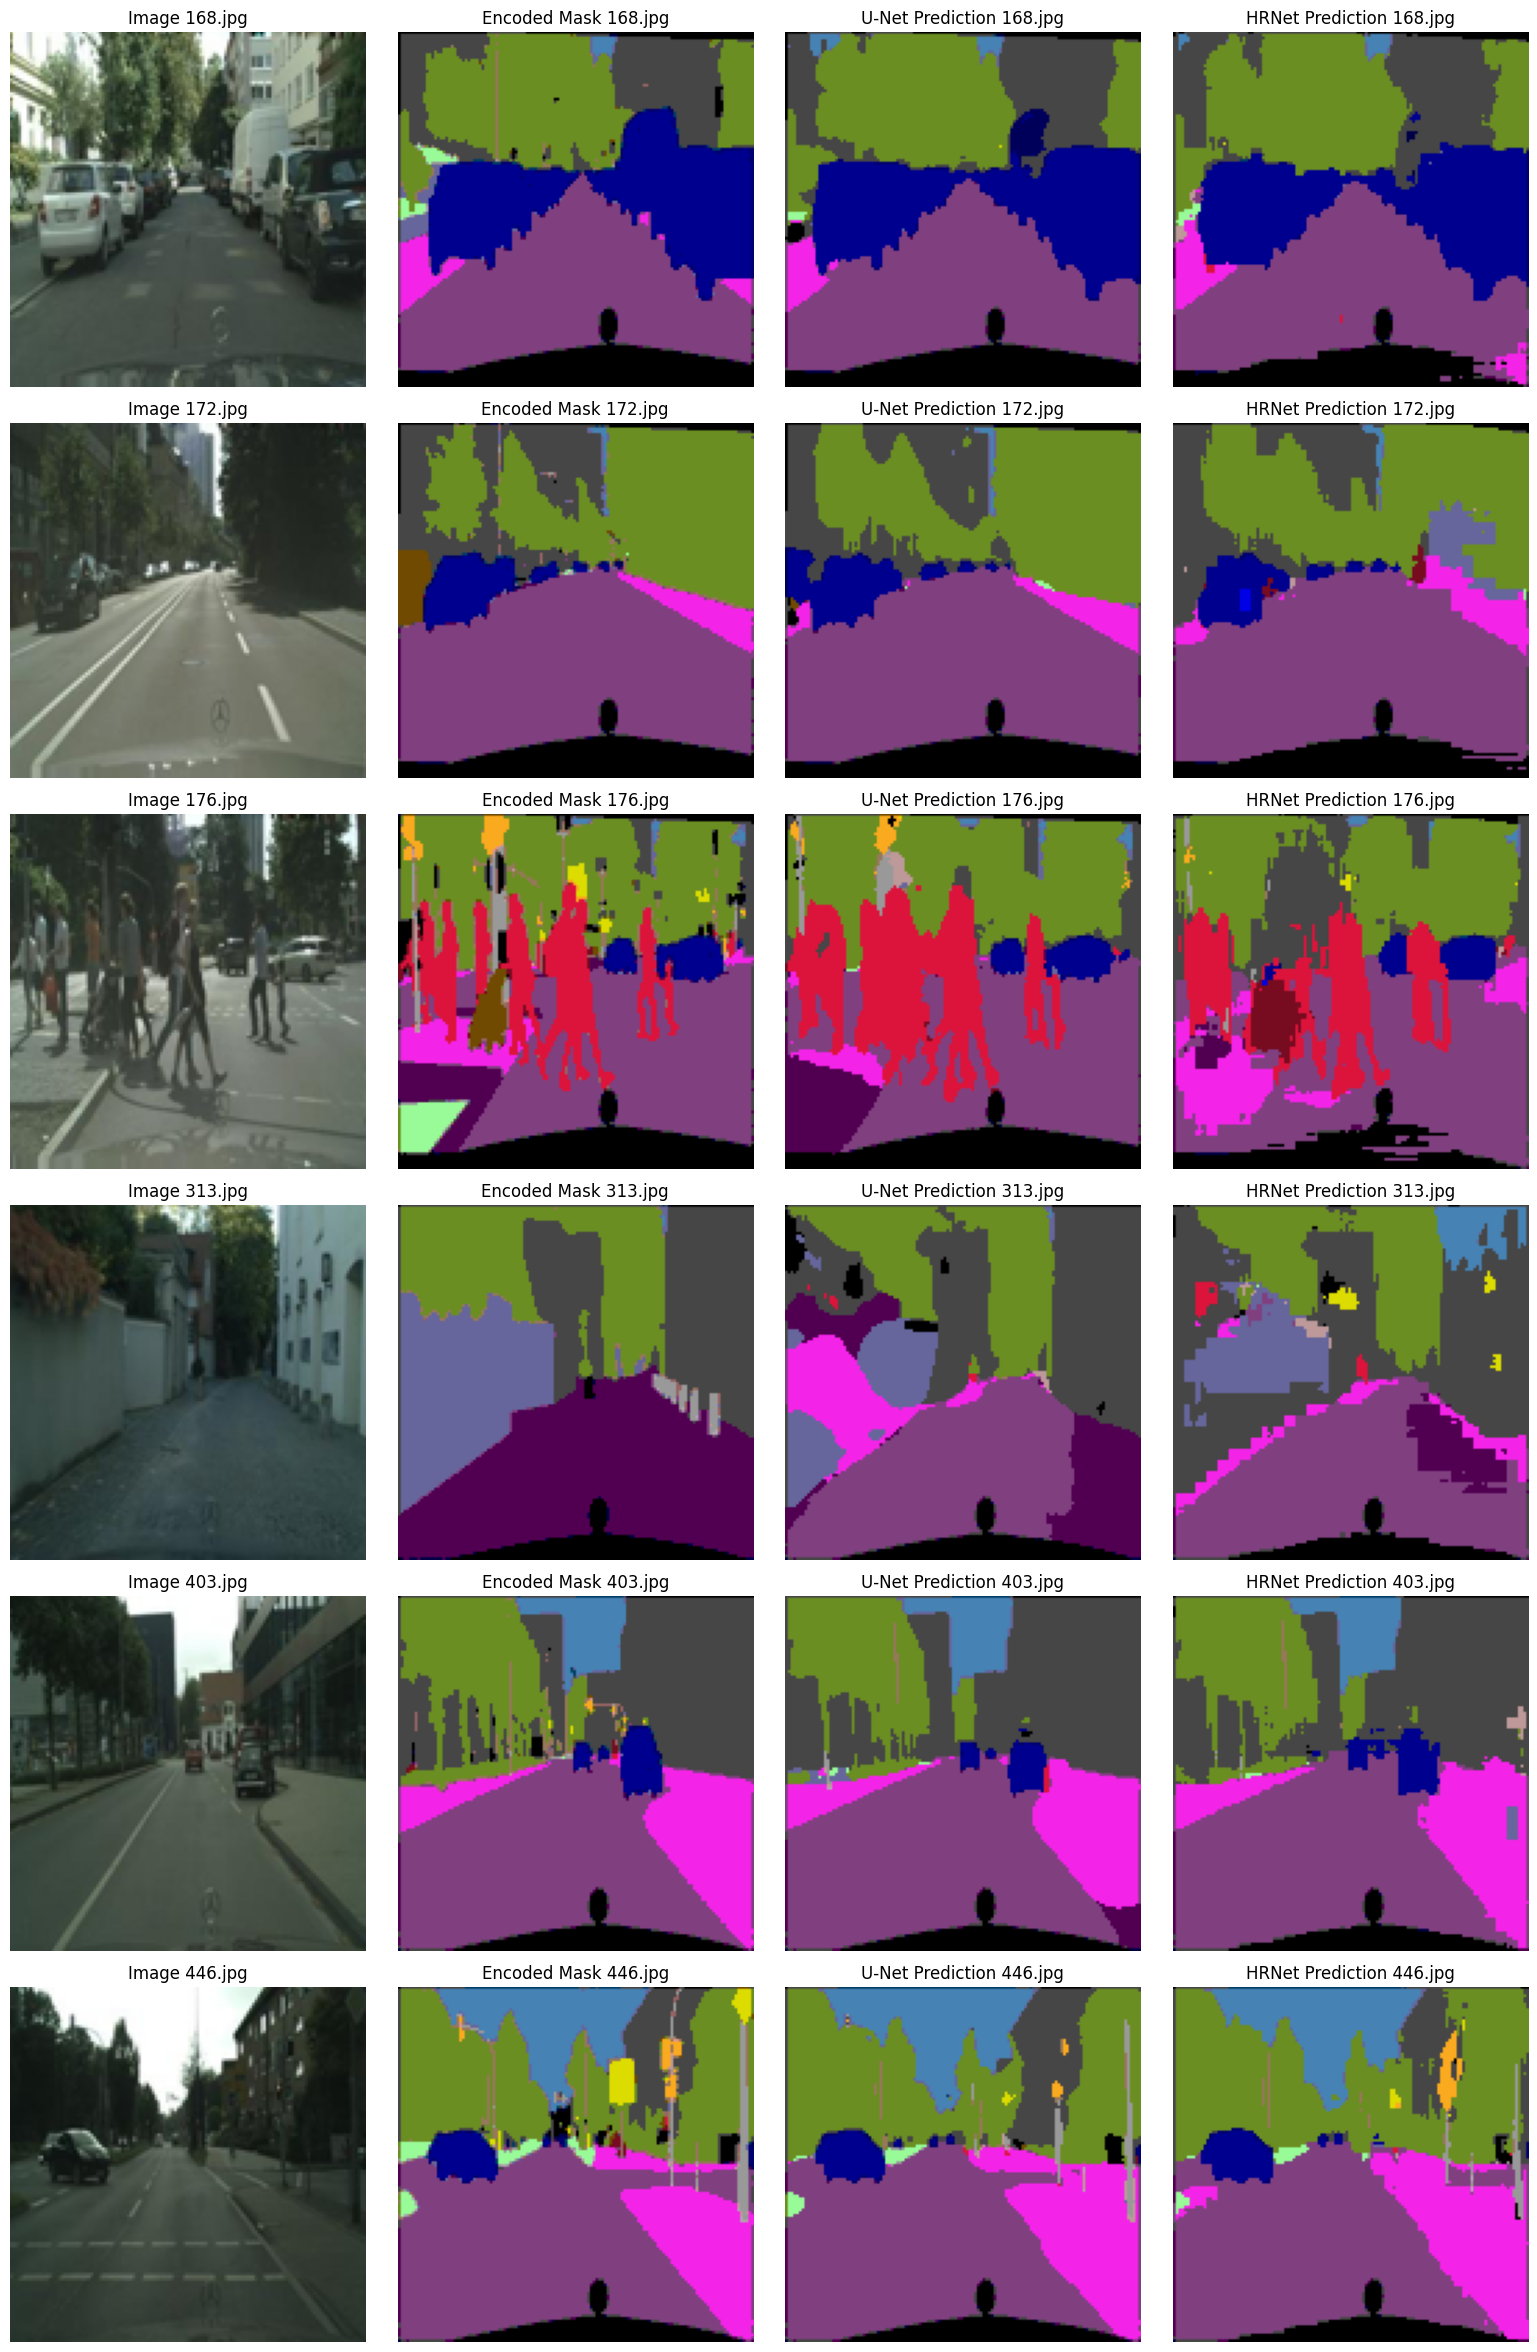

In [13]:
plt.style.use("default")
samples = [168, 172, 176, 313, 403, 446]
plt.figure(figsize=[20, len(samples) * 5])
names = [f'{_}.jpg' for _ in samples]

for i, name in enumerate(names):
# for i, name in enumerate(os.listdir(val_path)[:4]):
    img, mask, _ = preprocess(os.path.join(val_path,name),IMAGE_SIZE)
    mask_encoded = np.zeros([mask.shape[0], mask.shape[1], 3])

    # pred of unet
    pred_unet = model_unet.predict(img.reshape([1] + IMAGE_SHAPE))
    pred_unet = np.squeeze(np.argmax(pred_unet, axis=-1))

    output_unet = np.zeros([mask.shape[0], mask.shape[1], 3])
    
    # pred of hrnet
    pred_hrnet = model_hrnet.predict(img.reshape([1] + IMAGE_SHAPE))
    pred_hrnet = np.squeeze(np.argmax(pred_hrnet, axis=-1))

    output_hrnet = np.zeros([mask.shape[0], mask.shape[1], 3])
    
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            mask_encoded[row, col, :] = id2color[mask[row, col]]
            mask_encoded = mask_encoded.astype('uint8')
                     
            output_unet[row, col, :] = id2color[pred_unet[row, col]]
            output_unet = output_unet.astype('uint8')

            output_hrnet[row, col, :] = id2color[pred_hrnet[row, col]]
            output_hrnet = output_hrnet.astype('uint8')


            
    plt.subplot(len(samples), 4, i*4 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(name))
    
    plt.subplot(len(samples), 4, i*4 + 2)
    plt.imshow(mask_encoded)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(name))
    
    plt.subplot(len(samples), 4, i*4 + 3)
    plt.imshow(output_unet)
    plt.axis('off')
    plt.gca().set_title('U-Net Prediction {}'.format(name))

    plt.subplot(len(samples), 4, i*4 + 4)
    plt.imshow(output_hrnet)
    plt.axis('off')
    plt.gca().set_title('HRNet Prediction {}'.format(name))
    # plt.close()
    
plt.subplots_adjust(wspace=0, hspace=0.1)
# plt.savefig('pic.jpg')

# Test with url

In [14]:
def segment_url(model, url):
    urllib.request.urlretrieve(url, 'test.png')
    img = cv2.imread('test.png')
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # normalize input image
    img = np.array(img) / 255
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp2 = np.zeros([img.shape[0], img.shape[1], 3])
    
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(1, 2, 1)    
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2) 
    plt.imshow(tmp2)
    plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)   

1/1 [==============================] - 0s 32ms/step


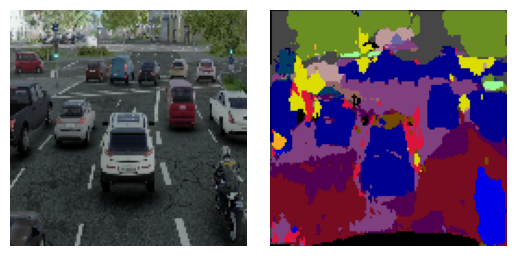

In [15]:
segment_url(model_unet ,'https://www.cognata.com/wp-content/uploads/2020/01/slide3b-1.jpg')

1/1 [==============================] - 0s 24ms/step


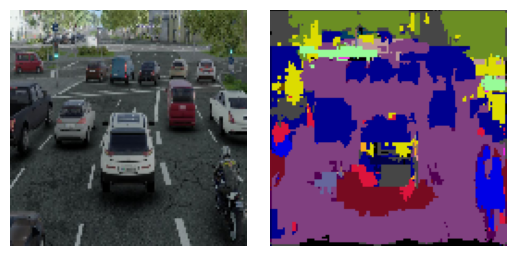

In [16]:
segment_url(model_hrnet ,'https://www.cognata.com/wp-content/uploads/2020/01/slide3b-1.jpg')